In [75]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import os
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class cifarDataset(Dataset):
    def __init__(self, csv, dir_name, transform=None):
        self.annotations = pd.read_csv(os.path.join(dir_name, csv))
        self.dir_name = dir_name
        self.transform = transform
        self.num_to_word = dict(enumerate((np.sort(self.annotations.iloc[:, 1].unique()))))
        self.word_to_num = {value: key for (key, value) in self.num_to_word.items()}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        image_path = self.annotations.iloc[index, 0]
        image = cv2.imread(os.path.join(self.dir_name, image_path))
        image = cv2.resize(image, (32,32))
        label = torch.tensor(self.word_to_num[self.annotations.iloc[index, 1]], dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        # return image_path when creating weighted csv
        return image, label# ,image_path


In [23]:
import torch
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import ResNet18
import os
#from dataset import cifarDataset
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hyperparameters
lr = 2e-5
batch_size = 1000
weight_decay = 1e-4
epochs = 30
transform = transforms.ToTensor()
train_accuracy = []
test_accuracy = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_fn(train_loader, model, optimizer, loss_fn):
    model.train()
    loop = tqdm(train_loader, leave=True)

    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(loop):
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += int(sum(out.argmax(axis=1) == y))
        total += y.size(0)

        # Update the progress bar
        loop.set_postfix(loss=loss.item())

    accu = 100. * (correct / total)
    train_accuracy.append(accu)


def test_fn(test_loader, model):
    model.eval()
    loop = tqdm(test_loader, leave=True)

    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loop):
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct += int(sum(out.argmax(axis=1) == y))
            total += y.size(0)

    accu = 100. * (correct / total)
    print(accu)
    test_accuracy.append(accu)


def main():
    torch.cuda.empty_cache()
    model = ResNet18()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    dir_name = "dataset"
    csv = "data/cifar100_nl_clean.csv"
    csv_test = "data/cifar100_nl_test.csv"
    dataset = cifarDataset(csv=csv, dir_name=dir_name, transform=transform)
    test_set = cifarDataset(csv=csv_test, dir_name=dir_name,
                            transform=transform)
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 9998])
    train_loader = DataLoader(dataset=train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=False)
    val_loader = DataLoader(dataset=val_set,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False)
    test_loader = DataLoader(dataset=test_set,
                             batch_size=batch_size,
                             shuffle=True)

    for epoch in range(epochs):
        train_fn(train_loader, model, optimizer, loss_fn)
        test_fn(test_loader, model)
        
    torch.save(model.state_dict(), "modelStates/baseModel.pth")

In [24]:
main()

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


3.5207041408281654


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


12.03240648129626


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


15.303060612122424


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


17.663532706541307


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


19.93398679735947


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


21.404280856171233


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


23.084616923384676


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


23.49469893978796


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


25.365073014602917


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


25.75515103020604


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


25.45509101820364


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


25.95519103820764


100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


25.55511102220444


100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


26.34526905381076


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


25.40508101620324


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


24.684936987397478


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


24.2248449689938


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


24.094818963792758


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


22.874574914982997


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


22.434486897379475


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


22.304460892178433


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


21.984396879375875


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


21.384276855371073


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


20.874174834966993


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


20.654130826165233


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


20.534106821364272


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


19.78395679135827


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


19.653930786157233


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


19.733946789357873


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

19.82396479295859


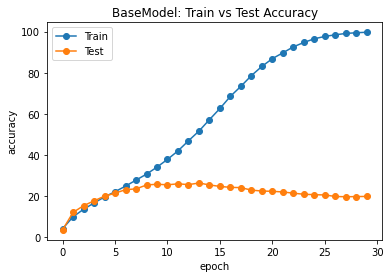

In [27]:
plt.plot(train_accuracy, '-o')
plt.plot(test_accuracy, '-o')
plt.legend(['Train','Test'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('BaseModel: Train vs Test Accuracy')
plt.show()

In [28]:
baseModelScores = pd.DataFrame({"train_accuracy":train_accuracy, "test_accuracy":test_accuracy})
baseModelScores

,train_accuracy,test_accuracy
0,4.0600,3.520704
1,9.8900,12.032406
2,13.5575,15.303061
3,16.6225,17.663533
4,19.5625,19.933987
5,22.1275,21.404281
6,24.8200,23.084617
7,27.7500,23.494699
8,30.6625,25.365073
9,34.0775,25.755151


In [29]:
baseModelScores.iloc[::2,:]

,train_accuracy,test_accuracy
0,4.0600,3.520704
2,13.5575,15.303061
4,19.5625,19.933987
6,24.8200,23.084617
8,30.6625,25.365073
10,37.8525,25.455091
12,46.8925,25.555111
14,57.1900,25.405081
16,68.5500,24.224845
18,78.6275,22.874575


In [32]:
baseModelScores["test_accuracy"].mean()

21.377275455091016

In [47]:
import torch
import torch.optim as optim
import torchvision.transforms.functional as FT
from torchvision.datasets import CIFAR100
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import ResNet18
import os
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

# Hyperparameters
lr = 2e-5
batch_size = 1000
weight_decay = 1e-4
epochs = 50
transform = transforms.ToTensor()
train_accuracy = []
test_accuracy = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_fn(train_loader, model, optimizer, loss_fn):
    model.train()
    loop = tqdm(train_loader, leave=True)

    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(loop):
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += int(sum(out.argmax(axis=1) == y))
        total += y.size(0)

        # Update the progress bar
        loop.set_postfix(loss=loss.item())

    accu = 100. * (correct / total)
    train_accuracy.append(accu)

torch.cuda.empty_cache()
model = ResNet18()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()

dataset = CIFAR100(download=True,root="./trueCIFAR100",transform=transform)
train_set,_ = torch.utils.data.random_split(dataset, [5000, 45000])
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=False)

for epoch in range(epochs):
    train_fn(train_loader, model, optimizer, loss_fn)
torch.save(model.state_dict(), "modelStates/supervisorModel.pth")

Files already downloaded and verified


100%|██████████| 5/5 [00:02<00:00,  2.04it/s, loss=0.272]


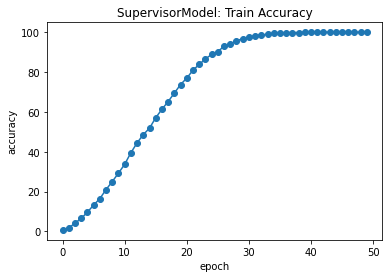

In [49]:
plt.plot(train_accuracy, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('SupervisorModel: Train Accuracy')
plt.show()

In [50]:
supervisorModelScores = pd.DataFrame({"train_accuracy":train_accuracy})
supervisorModelScores

,train_accuracy
0,0.76
1,1.72
2,4.16
3,6.50
4,9.66
5,13.22
6,16.46
7,20.98
8,25.02
9,29.24


In [51]:
supervisorModelScores.iloc[:30:2,:]

,train_accuracy
0,0.76
2,4.16
4,9.66
6,16.46
8,25.02
10,33.70
12,44.46
14,51.84
16,61.32
18,69.46


In [52]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2
import os
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [53]:
import torchvision

In [56]:
original_csv = "data/cifar100_nl_clean.csv"
dir_name = "dataset"
supervisor_model = model
sample_num = 49998

In [59]:
csv_file = pd.read_csv(os.path.join(dir_name, original_csv), header=None)
dataset = cifarDataset(csv=original_csv, dir_name=dir_name, transform=transforms.ToTensor())
batch_size = 1
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
supervisor_model.eval()
supervisor_model.to(device)
loss_fn = nn.CrossEntropyLoss()

file_names = []
labels = []
proportions = []
with torch.no_grad():
    for (x,y, image_path) in loader:
        x,y = x.to(device), y.to(device)
        out = supervisor_model(x)
        loss = 1. - loss_fn(out, y)
        proportions.append(float(loss))
        labels.append(int(y))
        file_names.append(image_path[0])

# Normalize proportions
proportions = (np.array(proportions) - min(proportions)) / max(proportions)
proportions = proportions/np.sum(proportions)
# Sample from newly created distribution
new_data = np.random.choice(file_names, sample_num, p=proportions)
final_csv = pd.DataFrame(columns=[0,1])
for i in new_data:
    final_csv = pd.concat([final_csv,csv_file[csv_file[0] == i]], ignore_index=True)
final_csv.to_csv("dataset/data/cifar100_weighted.csv",index=False)

In [60]:
weighted_data = pd.read_csv("dataset/data/cifar100_weighted.csv")

In [66]:
import torch
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import ResNet18
import os
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Hyperparameters
lr = 2e-5
batch_size = 1000
weight_decay = 1e-4
epochs = 30
transform = transforms.ToTensor()
train_accuracy = []
test_accuracy = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_fn(train_loader, model, optimizer, loss_fn):
    model.train()
    loop = tqdm(train_loader, leave=True)

    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(loop):
        x,y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += int(sum(out.argmax(axis=1) == y))
        total += y.size(0)

        # Update the progress bar
        loop.set_postfix(loss=loss.item())

    accu = 100. * (correct / total)
    train_accuracy.append(accu)


def test_fn(test_loader, model):
    model.eval()
    loop = tqdm(test_loader)

    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loop):
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct += int(sum(out.argmax(axis=1) == y))
            total += y.size(0)

    accu = 100. * (correct / total)
    print(accu)
    test_accuracy.append(accu)


def main():
    torch.cuda.empty_cache()
    model = ResNet18()
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    dir_name = "dataset"
    csv = "data/cifar100_weighted.csv"
    csv_test = "data/cifar100_nl_test.csv"
    dataset = cifarDataset(csv=csv, dir_name=dir_name, transform=transform)
    test_set = cifarDataset(csv=csv_test, dir_name=dir_name,
                            transform=transform)
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 9998])
    train_loader = DataLoader(dataset=train_set,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=False)
    val_loader = DataLoader(dataset=val_set,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False)
    test_loader = DataLoader(dataset=test_set,
                             batch_size=batch_size,
                             shuffle=True)

    for epoch in range(epochs):
        train_fn(train_loader, model, optimizer, loss_fn)
        test_fn(test_loader, model)
    torch.save(model.state_dict(), "modelStates/studentModel.pth")

In [67]:
main()

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


2.850570114022805


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


11.802360472094419


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


15.433086617323466


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


17.283456691338266


100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


18.50370074014803


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


19.76395279055811


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


21.014202840568114


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


21.344268853770753


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


21.094218843768754


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


20.824164832966595


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


21.144228845769153


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


20.60412082416483


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


20.384076815363073


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


19.83396679335867


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


19.29385877175435


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


18.96379275855171


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


19.243848769753953


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


18.80376075215043


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


18.333666733346668


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


18.27365473094619


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


18.12362472494499


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


17.89357871574315


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


17.663532706541307


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


17.16343268653731


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


17.353470694138828


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


17.59351870374075


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


17.233446689337867


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


17.183436687337466


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


17.143428685737145


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

16.983396679335865


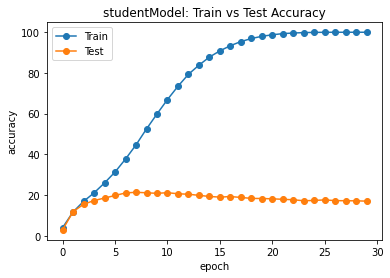

In [68]:
plt.plot(train_accuracy, '-o')
plt.plot(test_accuracy, '-o')
plt.legend(['Train','Test'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('studentModel: Train vs Test Accuracy')
plt.show()

In [69]:
studentModelScores = pd.DataFrame({"train_accuracy":train_accuracy, "test_accuracy":test_accuracy})
studentModelScores

,train_accuracy,test_accuracy
0,3.9325,2.850570
1,11.6875,11.802360
2,16.8525,15.433087
3,21.0475,17.283457
4,25.9300,18.503701
5,31.2900,19.763953
6,37.6725,21.014203
7,44.6275,21.344269
8,52.4775,21.094219
9,59.8300,20.824165


In [71]:
studentModelScores.iloc[::2,:]

,train_accuracy,test_accuracy
0,3.9325,2.850570
2,16.8525,15.433087
4,25.9300,18.503701
6,37.6725,21.014203
8,52.4775,21.094219
10,66.9300,21.144229
12,79.3450,20.384077
14,87.8075,19.293859
16,93.4075,19.243849
18,96.9100,18.333667


In [72]:
studentModelScores["test_accuracy"].mean()

17.970927518837104

In [74]:
studentModelScores["test_accuracy"].max()

21.344268853770753